In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np
import math

In [2]:
from planetengine.utilities import quickShow

In [3]:
mesh = uw.mesh.FeMesh_Cartesian(
    elementRes = (64, 64),
    )

In [4]:
temperatureField = uw.mesh.MeshVariable(mesh, 1)
temperatureDotField = uw.mesh.MeshVariable(mesh, 1)
pressureField = uw.mesh.MeshVariable(mesh.subMesh, 1)
velocityField = uw.mesh.MeshVariable(mesh, 2)

In [5]:
inner = mesh.specialSets["MinJ_VertexSet"]
outer = mesh.specialSets["MaxJ_VertexSet"]
sides = mesh.specialSets["MaxI_VertexSet"] + mesh.specialSets["MinI_VertexSet"]

velBC = uw.conditions.DirichletCondition(
    variable = velocityField,
    indexSetsPerDof= (sides, inner + outer),
    )

tempBC = uw.conditions.DirichletCondition(
    variable = temperatureField,
    indexSetsPerDof = (inner + outer,)
    )

In [6]:
isoviscous = fn.misc.constant(True)

invDensityFn = temperatureField * 1e7
buoyancyFn = invDensityFn * [0., 1.]
magnitude = fn.math.sqrt(fn.coord()[0]**2 + fn.coord()[1]**2)
depthFn = mesh.maxCoord[1] - magnitude
yieldStressFn = 4e5 + (1e7 * depthFn)
secInvFn = fn.tensor.second_invariant(fn.tensor.symmetric(velocityField.fn_gradient))
plasticViscFn = yieldStressFn / (2. * secInvFn + 1e-18)
creepViscFn = fn.math.pow(fn.misc.constant(3e4), -1. * (temperatureField - 1.))
viscoplastic = fn.misc.min(3e4, fn.misc.max(1., fn.misc.min(creepViscFn, plasticViscFn)))

viscosityFn = fn.branching.conditional([(isoviscous, 1.), (True, viscoplastic)])

stokes = uw.systems.Stokes(
    velocityField = velocityField,
    pressureField = pressureField,
    conditions = [velBC,],
    fn_viscosity = viscosityFn,
    fn_bodyforce = buoyancyFn,
    )

solver = uw.systems.Solver(stokes)

In [7]:
def solve():
    velocityField.data[:] = 0.
    solver.solve(
        nonLinearIterate = not isoviscous.value,
        )

In [8]:
class Sinusoidal:

    def __init__(
            self, variableArray, coordArray,
            pert = 0.2,
            freq = 1.,
            tempRange = (0., 1.),
            phase = 0.,
            boxDims = (1., 1.), # length, height
            ):
        self.variableArray = variableArray
        self.coordArray = coordArray
        self.freq = freq
        self.tempRange = tempRange
        self.phase = phase
        self.pert = pert
        self.boxDims = boxDims

    def sinusoidal_IC(self):
        boxLength, boxHeight = self.boxDims
        tempMin, tempMax = self.tempRange
        deltaT = self.tempRange[1] - self.tempRange[0]
        pertArray = \
            self.pert \
            * np.cos(np.pi * (self.phase + self.freq * self.coordArray[:,0])) \
            * np.sin(np.pi * self.coordArray[:,1])
        outArray = tempMin + deltaT * (boxHeight - self.coordArray[:,1]) + pertArray
        outArray = np.clip(outArray, tempMin, tempMax)
        outArray = np.array([[item] for item in outArray])
        return outArray

    def apply(self):
        self.variableArray[:] = self.sinusoidal_IC()

In [9]:
def initialise():
    tempFn = Sinusoidal(temperatureField.data, mesh.data)
    tempFn.apply()
    temperatureField.data[outer] = 0.
    temperatureField.data[inner] = 1.
    velocityField.data[:] = [0., 0.]
    pressureField.data[:] = 0.
    temperatureDotField.data[:] = 0.

In [10]:
initialise()


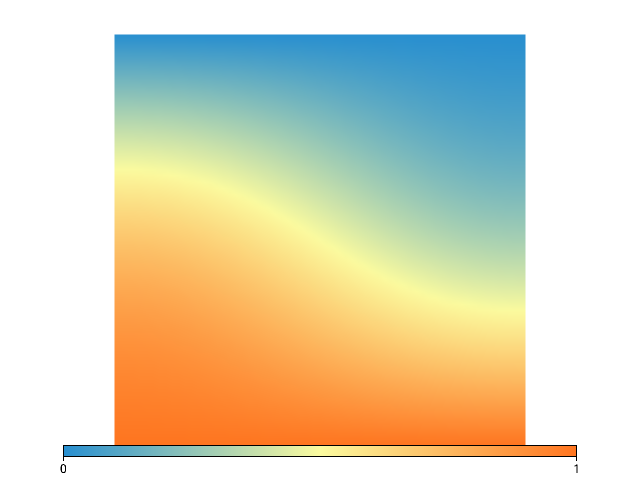

In [11]:
quickShow(temperatureField)

In [12]:
def test(isovisc):
    isoviscous.value = isovisc
    print("Isoviscous: ", isovisc)
    initialise()
    solve()
    velCopy = velocityField.data.copy()
    solve()
    print("Vel field unchanged: ", np.allclose(velCopy, velocityField.data))

In [13]:
test(True)

Isoviscous:  True
Vel field unchanged:  True


In [14]:
test(False)

Isoviscous:  False
Vel field unchanged:  True
